# 集成方法

## 概述
概念: 是对其他算法进行组合的一种形式。

集成方法:
-   投票选举(bagging: 自举汇聚法 bootstrap aggregating): 是基于数据随机重抽样分类器构造的方法
-   再学习(boosting): 是基于所有分类器的加权求和的方法

## 场景
目前 bagging 方法最流行的版本是: 随机森林(random forest)

目前 boosting 方法最流行的版本是: AdaBoost

**bagging 和 boosting 的区别**
-   bagging 是一种与 boosting 很类似的技术, 所使用的多个分类器的类型（数据量和特征量）都是一致的。
-   bagging 是由不同的分类器（1.数据随机化 2.特征随机化）经过训练，综合得出的出现最多分类结果；boosting 是通过调整已有分类器错分的那些数据来获得新的分类器，得出目前最优的结果。
-   bagging 中的分类器权重是相等的；而 boosting 中的分类器加权求和，所以权重并不相等，每个权重代表的是其对应分类器在上一轮迭代中的成功度。

## 随机森林
随机森林指的是利用多棵树对样本进行训练并预测的一种分类器。

**数据的随机化**
-   采取有放回的抽样方式 构造子数据集，保证不同子集之间的数量级一样（不同子集／同一子集 之间的元素可以重复）
    -   有放回的准确率在: 70% 以上， 无放回的准确率在: 60% 以上
-   利用子数据集来构建子决策树，将这个数据放到每个子决策树中，每个子决策树输出一个结果。
-   然后统计子决策树的投票结果，得到最终的分类 就是 随机森林的输出结果。

**待选特征的随机化**
-   子树从所有的待选特征中随机选取一定的特征
-   在选取的特征中选取最优的特征
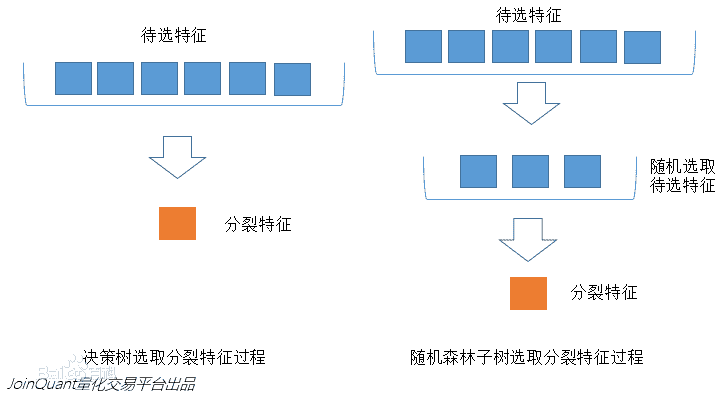

In [19]:
import numpy as np
from random import randrange

In [20]:
def loadDataSet(fileName):
    dataMat = []

    with open(fileName) as f:
        for line in f:
            lineArr = line.strip().split(',')
            dataLine = [float(x) for x in lineArr[:-1]]
            dataLine.append(lineArr[-1])
            dataMat.append(dataLine)

    return np.array(dataMat)

# 生成一个 n 折的数据集划分
def crossValidationSplit(dataSet, n_folds):
    dataSetSplit = []
    dataSetCopy = list(dataSet)
    foldSize = len(dataSet) // n_folds

    for _ in range(n_folds):
        fold = []
        while len(fold) < foldSize:
            index = randrange(len(dataSetCopy))
            fold.append(dataSetCopy.pop(index))
        dataSetSplit.append(fold)
    
    return dataSetSplit

# 根据特征索引和特征值划分数据集
def testSplit(index, value, dataSet):
    left, right = [], []
    for row in dataSet:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# 计算Gini指数
def giniIndex(groups, classValues):
    """计算Gini指数，用于衡量数据集的纯度。

    Args:
        groups (list): 包含左、右两部分数据的列表。
        class_values (list): 数据集的所有分类标签。

    Returns:
        float: Gini指数。
    """
    gini = 0.0
    totalSize = sum(len(group) for group in groups)

    for group in groups:
        size = len(group)
        if size == 0:
            continue

        score = 0.0
        for classVal in classValues:
            p = [row[-1] for row in group].count(classVal) / size
            score += p** 2
        
        gini += (1 - score) * (size / totalSize)
    
    return gini

# 选择最优的特征和特征值
def getSplit(dataSet, nFeatures):
    """寻找分割数据集的最佳特征和特征值。

    Args:
        dataset (list): 数据集。
        n_features (int): 特征数量的子集，用于随机森林中的特征选择。

    Returns:
        dict: 包含最佳特征索引、特征值及分割后的数据集。
    """

    classValues = list(set(row[-1] for row in dataSet))
    bestIndex, bestValue, bestScore, bestGroups = None, None, float('inf'), None
    features = []

    # 随机选择特征
    while len(features) < nFeatures:
        index = randrange(len(dataSet[0]) - 1)
        if index not in features:
            features.append(index)

    # 寻找最优分割点
    for index in features:
        for row in dataSet:
            groups = testSplit(index, row[index], dataSet)
            gini = giniIndex(groups, classValues)
            if gini < bestScore:
                bestIndex, bestValue, bestScore, bestGroups = index, row[index], gini, groups

    return {'index': bestIndex, 'value': bestValue, 'groups': bestGroups}



# 终止节点生成
def toTerminal(group):
    """
    创建一个终止节点，即叶节点。

    Args:
        group (list): 分割后的一组数据。

    Returns:
        分类标签: 该组数据中出现次数最多的标签。
    """
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# 递归分割节点
def split(node, maxDepth, minSize, nFeatures, depth):
    """
    递归分割节点，构建决策树。

    Args:
        node (dict): 当前节点信息。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        n_features (int): 选取的特征数量。
        depth (int): 当前节点深度。
    """
    left, right = node['groups']
    # 删除已经分割的数据, 以免重复分割
    del(node['groups'])

    if not left or not right:
        node['left'] = node['right'] = toTerminal(left + right)
        return
    
    if depth >= maxDepth:
        node['left'], node['right'] = toTerminal(left), toTerminal(right)
        return
    
    if len(left) <= minSize:
        node['left'] = toTerminal(left)
    else:
        node['left'] = getSplit(left, nFeatures)
        split(node['left'], maxDepth, minSize, nFeatures, depth + 1)
    
    if len(right) <= minSize:
        node['right'] = toTerminal(right)
    else:
        node['right'] = getSplit(right, nFeatures)
        split(node['right'], maxDepth, minSize, nFeatures, depth + 1)

# 构建决策树
def buildTree(train, maxDepth, minSize, nFeatures):
    """
    构建决策树。

    Args:
        train (list): 训练数据。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        n_features (int): 选取的特征数量。

    Returns:
        dict: 决策树。
    """
    root = getSplit(train, nFeatures)
    split(root, maxDepth, minSize, nFeatures, 1)
    return root

# 预测
def predict(node, row):
    """
    对输入数据进行预测。

    Args:
        node (dict): 决策树节点。
        row (list): 输入数据行。

    Returns:
        预测分类: 树预测的分类结果。
    """
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
# 随机森林，bagging预测
def baggingPredict(trees, row):
    """
    对输入数据进行bagging预测。

    Args:
        trees (list): 决策树集合。
        row (list): 输入数据行。

    Returns:
        预测分类: 多数决策树的预测结果。
    """

    results = [predict(tree, row) for tree in trees]
    return max(set(results), key=results.count)

# 随机抽取创建子样本
def subsample(dataSet, ratio):
    """
    从数据集中随机抽样创建子样本。

    Args:
        dataset (list): 数据集。
        ratio (float): 抽样比例。

    Returns:
        list: 子样本数据集。
    """

    sample = []
    nSample = round(len(dataSet) * ratio)
    
    while len(sample) < nSample:
        index = randrange(len(dataSet))
        sample.append(dataSet[index])
    return sample

# 随机森林算法
def randomForest(train, test, maxDepth, minSize, sampleRatio, nTrees, nFeatures):
    """
    构建随机森林模型并进行预测。

    Args:
        train (list): 训练数据。
        test (list): 测试数据。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        sample_ratio (float): 子样本比例。
        n_trees (int): 决策树的数量。
        n_features (int): 随机选取的特征数量。

    Returns:
        list: 测试数据的预测结果。
    """

    trees = []
    for _ in range(nTrees):
        sample = subsample(train, sampleRatio)
        tree = buildTree(sample, maxDepth, minSize, nFeatures)
        trees.append(tree)
    
    predictions = [baggingPredict(trees, row) for row in test]
    return predictions

# 计算分类准确率
def accuracyMetric(actual, predicted):
    """计算预测的准确率。

    Args:
        actual (list): 实际标签。
        predicted (list): 预测标签。

    Returns:
        float
    """

    correct = sum(1 for i in range(len(actual)) if actual[i] == predicted[i])
    return correct / len(actual) * 100.0

# 交叉验证
def evaluate(dataSet, algorithm, nFolds, *args):
    """使用交叉验证评估算法性能。

    Args:
        dataset (list): 数据集。
        algorithm (function): 使用的算法函数。
        n_folds (int): 交叉验证折数。
        *args: 算法需要的其他参数。

    Returns:
        list: 每一折的准确率。
    """

    folds = crossValidationSplit(dataSet, nFolds)
    scores = []

    for fold in folds:
        train = sum([f for i, f in enumerate(folds) if i != fold], [])
        test = fold
        for row in test:
            row[-1] = None
        predicted = algorithm(train, test, *args)
        actual = [row[-1] for row in test]
        accuracy = accuracyMetric(actual, predicted)
        scores.append(accuracy)
    
    return scores

In [21]:
if __name__ == '__main__':
    dataSet = loadDataSet('sonar-all-data.txt')
    print(dataSet.shape)

    nFolds = 5
    maxDepth = 20 #决策树深度不能太深，不然容易导致过拟合
    minSize = 1
    sampleSize = 1.0
    nFeatures = int(np.sqrt(len(dataSet[0]) - 1))

    for nTrees in [1, 5, 10]: # 理论上树是越多越好
        scores = evaluate(dataSet, randomForest, nFolds, maxDepth, minSize, sampleSize, nTrees, nFeatures)
        print('Trees: %d' % nTrees)
        print('Scores: %s' % scores)
        print('Mean Accuracy: %.3f%%' % (sum(scores) / len(scores)))

(208, 61)
Trees: 1
Scores: [65.85365853658537, 78.04878048780488, 82.92682926829268, 90.2439024390244, 100.0]
Mean Accuracy: 83.415%
Trees: 5
Scores: [100.0, 100.0, 100.0, 100.0, 100.0]
Mean Accuracy: 100.000%
Trees: 10
Scores: [100.0, 100.0, 100.0, 100.0, 100.0]
Mean Accuracy: 100.000%


## AdaBoost
adaptive boosting: 自适应 boosting

### 原理
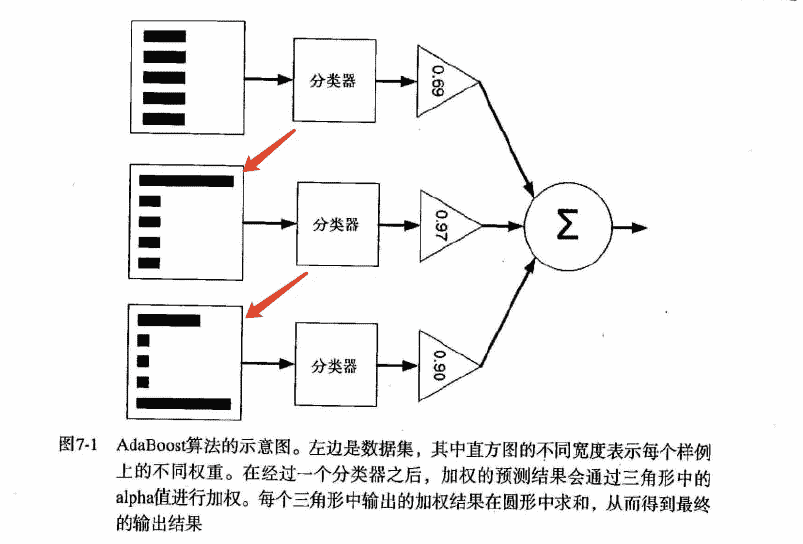

### 开发流程
收集数据: 可以使用任意方法

准备数据: 依赖于所使用的弱分类器类型，本章使用的是单层决策树，这种分类器可以处理任何数据类型。
    当然也可以使用任意分类器作为弱分类器，第2章到第6章中的任一分类器都可以充当弱分类器。
    作为弱分类器，简单分类器的效果更好。

分析数据: 可以使用任意方法。

训练算法: AdaBoost 的大部分时间都用在训练上，分类器将多次在同一数据集上训练弱分类器。

测试算法: 计算分类的错误率。

使用算法: 通SVM一样，AdaBoost 预测两个类别中的一个。如果想把它应用到多个类别的场景，那么就要像多类 SVM 中的做法一样对 AdaBoost 进行修改。

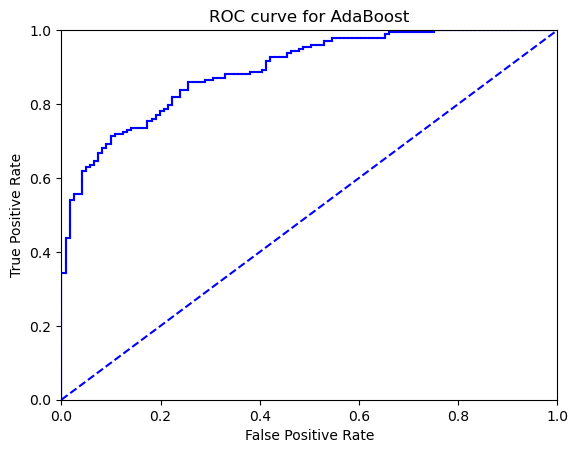

AUC:  0.8918191104095092
Error rate: 0.19402985074626866


In [25]:
def loadDataSet(fileName):
    dataArr, labelArr = [], []
    with open(fileName) as file:
        for line in file:
            lineArr = line.strip().split('\t')
            dataArr.append([float(x) for x in lineArr[: - 1]])
            labelArr.append(float(lineArr[-1]))
    return np.array(dataArr), np.array(labelArr)

def stumpClassify(dataArr, featureIndex, threshold, inequality):
    """
    使用单层决策树对数据集进行分类。
    
    Parameters:
    - dataArr: 二维数组，包含样本特征。
    - featureIndex: 整数，指定的特征索引。
    - threshold: 浮点数，用于分类的阈值。
    - inequality: 字符串，'lt' 表示小于阈值分类为 -1，'gt' 表示大于阈值分类为 -1。
    
    Returns:
    - predictions: 一维数组，分类结果。
    """
    predictions = np.ones(dataArr.shape[0])
    if inequality == 'lt':
        predictions[dataArr[:, featureIndex] <= threshold] = -1.0
    else:
        predictions[dataArr[:, featureIndex] > threshold] = -1.0
    return predictions


def buildStump(dataArr, labelArr, weights):
    """
    构建单层决策树，找到最佳分类器。
    
    Parameters:
    - dataArr: 二维数组，包含样本特征。
    - labelArr: 一维数组，包含样本标签。
    - weights: 一维数组，包含每个样本的权重。
    
    Returns:
    - bestStump: 字典，保存最佳单层决策树的信息（特征索引、阈值、方向）。
    - minError: 浮点数，最低分类错误率。
    - bestEstimates: 一维数组，最佳分类结果。
    """
    m, n = dataArr.shape
    numSteps = 10.0
    bestStump = {}
    bestEstimates = np.zeros(m)
    minError = np.inf

    for i in range(n):
        featureMin, featureMax = dataArr[:, i].min(), dataArr[:, i].max()
        stepSize = (featureMax - featureMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequality in ['lt', 'gt']:
                threshold = featureMin + float(j) * stepSize
                predictions = stumpClassify(dataArr, i, threshold, inequality)
                errorArr = np.ones(m)
                errorArr[predictions == labelArr] = 0
                # np.dot 返回两个数组的点积
                weightedError = np.dot(weights, errorArr)

                if weightedError < minError:
                    minError = weightedError
                    bestEstimates = predictions.copy()
                    bestStump = {'featureIndex': i, 'threshold': threshold, 'inequality': inequality}

    return bestStump, minError, bestEstimates

def adaBoostTrain(dataArr, labelArr, numIterations=40):
    """
    训练AdaBoost模型，通过迭代生成多个弱分类器。
    
    Parameters:
    - dataArr: 二维数组，包含样本特征。
    - labelArr: 一维数组，包含样本标签。
    - numIterations: 整数，指定迭代次数。
    
    Returns:
    - weakClassifiers: 列表，包含所有弱分类器信息。
    - aggEstimates: 一维数组，集成分类器的累计估计值。
    """

    weakClassifiers = []
    m = dataArr.shape[0]
    weights = np.ones(m) / m
    aggEstimates = np.zeros(m)

    for _ in range(numIterations):
        bestStump, err, estimates = buildStump(dataArr, labelArr, weights)
        alpha = 0.5 * np.log((1.0 - err) / max(err, 1e-16))
        bestStump['alpha'] = alpha
        weakClassifiers.append(bestStump)

        weights *= np.exp(-alpha * labelArr * estimates)
        weights /= weights.sum()

        aggEstimates += alpha * estimates
        if all(np.sign(aggEstimates) == labelArr):
            break
    
    return weakClassifiers, aggEstimates

def adaClassify(dataArr, classifiers):
    """
    使用训练好的AdaBoost模型对新数据进行分类。
    
    Parameters:
    - dataArr: 二维数组，包含待分类样本特征。
    - classifiers: 列表，包含训练好的弱分类器信息。
    
    Returns:
    - 一维数组，分类结果。
    """

    aggEstimates = np.zeros(dataArr.shape[0])
    for classifier in classifiers:
        estimates = stumpClassify(dataArr, classifier['featureIndex'], classifier['threshold'], classifier['inequality'])
        aggEstimates += classifier['alpha'] * estimates

    return np.sign(aggEstimates)

def plotRoc(predStrengths, classLabels):
    """
    绘制ROC曲线，并计算AUC面积。
    
    Parameters:
    - predStrengths: 一维数组，模型的预测强度。
    - classLabels: 一维数组，真实的样本标签。
    
    Returns:
    - None
    """
    import matplotlib.pyplot as plt
    ySum = 0.0
    numPosClass = sum(np.array(classLabels) == 1.0)
    yStep = 1 / float(numPosClass)
    xStep = 1 / float(len(classLabels) - numPosClass)
    sortedIndices = predStrengths.argsort()
    cur = (1.0, 1.0)

    fig = plt.figure()
    ax = plt.subplot(111)
    for index in sortedIndices:
        if classLabels[index] == 1.0:
            delX, delY = 0, yStep
        else:
            delX, delY = xStep, 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("AUC: ", ySum * xStep)

if __name__ == "__main__":
    dataArr, labelArr = loadDataSet("horseColicTraining2.txt")
    weakClassifiers, aggEstimates = adaBoostTrain(dataArr, labelArr, 40)
    plotRoc(aggEstimates, labelArr)

    dataArrTest, labelArrTest = loadDataSet("horseColicTest2.txt")
    predictions = adaClassify(dataArrTest, weakClassifiers)
    errorRate = np.mean(predictions != labelArrTest)
    print(f"Error rate: {errorRate}")
